<h3><b> Importing Library</b></h3>

In [1]:
# Importing Libraries
from __future__ import print_function
import os
import math 
import cv2 
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from keras.utils import np_utils
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
from keras import regularizers
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D,Flatten

<h3><b> Importing Dataset</b><h3>

In [2]:
# Load dataset
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

169009152/169001437 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


<h3><b> Preprocessing of the dataset</b></h3>

In [3]:
# Normalize the dataset
X_train = X_train/255
X_test = X_test/255

In [4]:
#Converting the testing and training dataset into float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [5]:
# Convert training and test labels to one hot matrices
y_train = keras.utils.to_categorical(y_train, 100)
y_test = keras.utils.to_categorical(y_test, 100)
print(y_train.shape)

(50000, 100)


<h3><b> Model Architecure</b></h3>

In [6]:
def inception_moduleA(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_3x3a,
                      filters_3x3b,
                  
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='elu')(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='elu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='elu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='elu')(x)
    conv_3x3a = Conv2D(filters_3x3a, (3, 3), padding='same', activation='elu')(conv_5x5)
    conv_3x3b = Conv2D(filters_3x3b, (3, 3), padding='same', activation='elu')(conv_3x3a)
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='elu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_3x3a, pool_proj], axis=-1, name=name)
    
    return output


def inception_moduleB(x,
                     filters_1x1modb,
                     filters_3x3_reducemodb,
                     filters_1x3modb,
                     filters_3x1modb,
                     filters_5x5_reducemodb,
                     filters_1x3amodb,
                      filters_3x1amodb,
                     filters_1x3bmodb,
                      filters_3x1bmodb,
                  
                     filters_pool_proj,
                     name=None):
    
    conv_1x1modb = Conv2D(filters_1x1modb, (1, 1), padding='same', activation='elu')(x)
    
    conv_3x3modb = Conv2D(filters_3x3_reducemodb, (1, 1), padding='same', activation='elu')(x)
    conv_1x3modb = Conv2D(filters_1x3modb, (1, 3), padding='same', activation='elu')(conv_3x3modb)
    conv_3x1modb = Conv2D(filters_3x1modb, (3, 1), padding='same', activation='elu')(conv_1x3modb)

    conv_5x5modb = Conv2D(filters_5x5_reducemodb, (1, 1), padding='same', activation='elu')(x)
    conv_1x3amodb = Conv2D(filters_1x3amodb, (1, 3), padding='same', activation='elu')(conv_5x5modb)
    conv_3x1amodb = Conv2D(filters_3x1amodb, (3, 1), padding='same', activation='elu')(conv_1x3amodb)
    conv_1x3bmodb = Conv2D(filters_1x3bmodb, (1, 3), padding='same', activation='elu')(conv_3x1amodb)
    conv_3x1bmodb = Conv2D(filters_3x1bmodb, (3, 1), padding='same', activation='elu')(conv_1x3bmodb)


    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)


    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='elu')(pool_proj)

    output = concatenate([conv_1x1modb, conv_3x1modb, conv_3x1bmodb, pool_proj], axis=-1, name=name)
    
    return output


def inception_moduleC(x,
                     filters_1x1modc,
                      filters_3x3_reducemodc,
                     filters_1x3modc,
                      filters_3x1modc,
                     filters_5x5_reducemodc,
                        filters_3x3amodc,
                      filters_1x3amodc,
                       filters_3x1amodc,
                      
                   
                     filters_pool_proj,
                     name=None):
    
    conv_1x1modc = Conv2D(filters_1x1modc, (1, 1), padding='same', activation='elu')(x)
    
    conv_3x3modc = Conv2D(filters_3x3_reducemodc, (1, 1), padding='same', activation='elu')(x)
    conv_1x3modc = Conv2D(filters_1x3modc, (1, 3), padding='same', activation='elu')(conv_3x3modc)
    conv_3x1modc = Conv2D(filters_3x1modc, (3, 1), padding='same', activation='elu')(conv_1x3modc)

    conv_5x5modc = Conv2D(filters_5x5_reducemodc, (1, 1), padding='same', activation='elu')(x)
    conv_3x3amodc = Conv2D(filters_3x3amodc, (1, 1), padding='same', activation='elu')(conv_5x5modc)

    conv_1x3amodc = Conv2D(filters_1x3amodc, (1, 3), padding='same', activation='elu')(conv_3x3amodc)
    conv_3x1amodc = Conv2D(filters_3x1amodc, (3, 1), padding='same', activation='elu')(conv_1x3amodc)



    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)


    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='elu')(pool_proj)

    output = concatenate([conv_1x1modc,conv_1x3modc, conv_3x1modc, conv_1x3amodc,conv_3x1amodc, pool_proj], axis=-1, name=name)
    
    return output



In [7]:
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(64, (3, 3), padding='same', strides=(2, 2), activation='elu', name='conv_1a_3x3/2')(input_layer)
x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='elu', name='conv_2a_3x3/1')(x)
x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='elu', name='conv_3a_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)
x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='elu', name='conv_4a_3x3/1')(x)
x = Conv2D(64, (3, 3), padding='same', strides=(2, 2), activation='elu', name='conv_5a_3x3/2')(x)
x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='elu', name='conv_6a_3x3/1')(x)

x = inception_moduleA(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_3x3a=32,
                     filters_3x3b=32,
                     filters_pool_proj=32,
                     name='inception_3a')
x = inception_moduleA(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_3x3a=32,
                     filters_3x3b=32,
                     filters_pool_proj=32,
                     name='inception_3aa')

#I am commenting the numbers of times module A, ModuleB is called as it is helping to increase my accuracy.In original InceptionV2 architecture ModuleA is called
#3 times, ModuleB is called 5 times and ModuleC is called 2 times:-
# x = inception_moduleA(x,
#                      filters_1x1=64,
#                      filters_3x3_reduce=96,
#                      filters_3x3=128,
#                      filters_5x5_reduce=16,
#                      filters_3x3a=32,
#                      filters_3x3b=32,
#                      filters_pool_proj=32,
#                      name='inception_3aaa')

x = inception_moduleB(x,
                     filters_1x1modb=64,
                     filters_3x3_reducemodb=96,
                     filters_1x3modb=128,
                     filters_3x1modb=128,
                     filters_5x5_reducemodb=16,
                     filters_1x3amodb=128,
                     filters_3x1amodb=128,
                     filters_1x3bmodb=128,
                     filters_3x1bmodb=128,
                   filters_pool_proj=32,
                     name='inception_4a')
x = inception_moduleB(x,
                     filters_1x1modb=64,
                     filters_3x3_reducemodb=96,
                     filters_1x3modb=128,
                     filters_3x1modb=128,
                     filters_5x5_reducemodb=16,
                     filters_1x3amodb=128,
                     filters_3x1amodb=128,
                     filters_1x3bmodb=128,
                     filters_3x1bmodb=128,
                     filters_pool_proj=32,
                     name='inception_4aa')
x = inception_moduleB(x,
                     filters_1x1modb=64,
                     filters_3x3_reducemodb=96,
                     filters_1x3modb=128,
                     filters_3x1modb=128,
                     filters_5x5_reducemodb=16,
                     filters_1x3amodb=128,
                     filters_3x1amodb=128,
                     filters_1x3bmodb=128,
                     filters_3x1bmodb=128,
                      filters_pool_proj=32,
             
                     name='inception_4aaa')
#I am commenting the numbers of times module A, ModuleB is called as it is helping to increase my accuracy.In original InceptionV2 architecture ModuleA is called
#3 times, ModuleB is called 5 times and ModuleC is called 2 times:-
# x = inception_moduleB(x,
#                      filters_1x1modb=64,
#                      filters_3x3_reducemodb=96,
#                      filters_1x3modb=128,
#                      filters_3x1modb=128,
#                      filters_5x5_reducemodb=16,
#                      filters_1x3amodb=128,
#                      filters_3x1amodb=128,
#                      filters_1x3bmodb=128,
#                      filters_3x1bmodb=128,
#                      filters_pool_proj=32,
#                      name='inception_4aaaa')
# x = inception_moduleB(x,
#                      filters_1x1modb=64,
#                      filters_3x3_reducemodb=96,
#                      filters_1x3modb=128,
#                      filters_3x1modb=128,
#                      filters_5x5_reducemodb=16,
#                      filters_1x3amodb=128,
#                      filters_3x1amodb=128,
#                      filters_1x3bmodb=128,
#                      filters_3x1bmodb=128,
#                      filters_pool_proj=32,
#                      name='inception_4aaaaa')

x = inception_moduleC(x,
                     filters_1x1modc=64,
                     filters_3x3_reducemodc=96,
                     filters_1x3modc=128,
                     filters_3x1modc=128,
                     filters_5x5_reducemodc=16,
                     filters_3x3amodc=128,
                     filters_1x3amodc=128,
                     filters_3x1amodc=128,
                     filters_pool_proj=32,
                    
                     name='inception_5a')
x = inception_moduleC(x,
                     filters_1x1modc=64,
                     filters_3x3_reducemodc=96,
                     filters_1x3modc=128,
                     filters_3x1modc=128,
                     filters_5x5_reducemodc=16,
                     filters_3x3amodc=128,
                     filters_1x3amodc=128,
                     filters_3x1amodc=128,
                     filters_pool_proj=32,
             
                     name='inception_5aa')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
# x = Dropout(0.4)(x)
x = Flatten()(x)
output = Dense(100, activation='softmax', name='output')(x)

In [8]:
model = Model(input_layer,  output)

In [9]:
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_1a_3x3/2 (Conv2D)          (None, 16, 16, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 16, 16, 64)   36928       conv_1a_3x3/2[0][0]              
__________________________________________________________________________________________________
conv_3a_3x3/1 (Conv2D)          (None, 16, 16, 64)   36928       conv_2a_3x3/1[0][0]              
_______________________________________________________________________________________

<h3><b> Model Compile</b></h3>

In [10]:
learning_rate = 0.001
batch_size = 128
lr_decay = 1e-6
#optimization details
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

In [11]:
# Create Checkpoint and Early Stopping
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("InceptionV2_SGD_NoRegularization.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

<h3><b> Train the Model</b><h3>

In [12]:
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=150, batch_size=256, callbacks=[checkpoint,early])


Epoch 1/150
196/196 [==============================] - ETA: 0s - loss: 4.6049 - accuracy: 0.0079
Epoch 00001: val_loss improved from inf to 4.60254, saving model to InceptionV2_SGD_NoRegularization.h5
196/196 [==============================] - 11s 57ms/step - loss: 4.6049 - accuracy: 0.0079 - val_loss: 4.6025 - val_accuracy: 0.0090
Epoch 2/150
195/196 [============================>.] - ETA: 0s - loss: 4.6004 - accuracy: 0.0123
Epoch 00002: val_loss improved from 4.60254 to 4.59764, saving model to InceptionV2_SGD_NoRegularization.h5
196/196 [==============================] - 10s 52ms/step - loss: 4.6004 - accuracy: 0.0123 - val_loss: 4.5976 - val_accuracy: 0.0145
Epoch 3/150
196/196 [==============================] - ETA: 0s - loss: 4.5920 - accuracy: 0.0189
Epoch 00003: val_loss improved from 4.59764 to 4.58298, saving model to InceptionV2_SGD_NoRegularization.h5
196/196 [==============================] - 10s 52ms/step - loss: 4.5920 - accuracy: 0.0189 - val_loss: 4.5830 - val_accurac

<h3><b> Graphs</b></h3>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


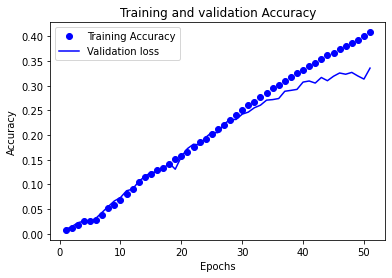

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, accuracy_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label='Validation loss')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


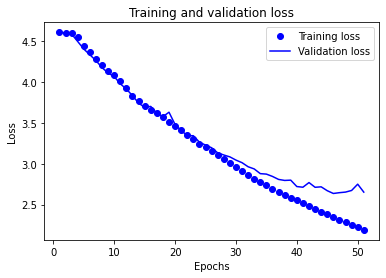

In [14]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


<h3><b> Metric Calculation</b></h3>

In [15]:
model1 = Model(input_layer,  output)
model1.load_weights("./InceptionV2_SGD_NoRegularization.h5")
#optimization details
learning_rate = 0.001
batch_size = 128
lr_decay = 1e-6
#optimization details
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

# Test the model
model.predict(X_test).argmax(-1)

y_true = y_test.argmax(-1)
y_pred = model.predict(X_test).argmax(-1)
# generate confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
confusion_matrix(y_true, y_pred)
# calculate prec, recall, accuracy
print("Prec: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Prec: 0.32165669292916405
Recall: 0.3258
Accuracy: 0.3258


<h3><b> References</b></h3>

In [16]:
#https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/
#https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf